# PALAVA: larger data simulation

Here we extend the previous demonstration to a 1000x1000 simulation, including some error. If you haven't seen the previous demo, please do, as it explains the process in greater detail.

In [170]:
import sys
sys.path.append("lib")
import random
from lib.data_sampler import DataSampler
from lib.palava import *
from lib.distributions import NormalNet
from lib.utils import Lambda, save_tensor, get_combined_norm
from itertools import permutations
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.max_open_warning'] = False
torch.manual_seed(0)
random.seed(0)

dir = "output"

We will simulate some data by designing a loadings and activation matrix. Details in "data_sampler.py". The complexity of these matrices will determine how difficult of a 'test' the data is for the model.

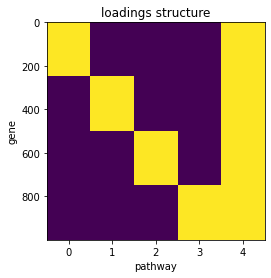

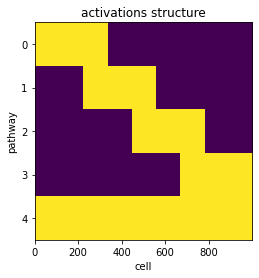

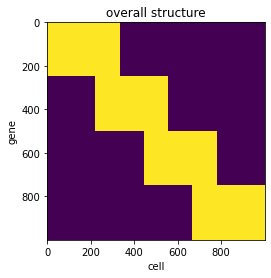

In [171]:
num_facs = 5
num_genes = 1000
num_cells = 1000

sampler = DataSampler(
  num_facs, num_genes, num_cells, overlap=True, dense_fac=True
)
sampler.save_matrices(dir + "/structure", overwrite=True, structure=True)

We then sample from the activations and loadings structure, then multiply to give the samples we will use throughout the simulation. We will sample from a normal distribution with mean 0, and the standard deviation will vary based on the structure given above. Dense pathways are given their own standard deviation. The model will attempt to relearn the specified activations, at least for the variables that are annotated with a pathway.

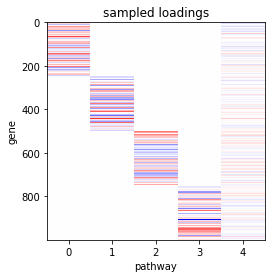

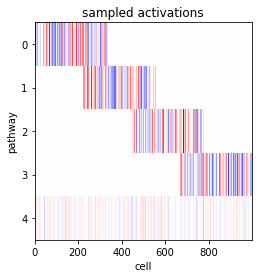

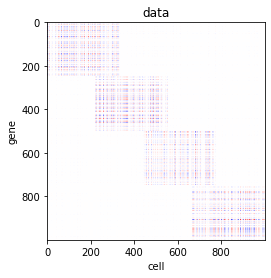

In [172]:
zero_sd = 0
nonzero_sd = 1
dense_path_sd = 0.2
noise = 0.001

sampler.sample_from_data_structure(zero_sd, nonzero_sd, dense_path_sd, noise)
sampler.save_matrices(dir + "/structure", overwrite=True, samples=True)

X = sampler.get_samples_by_row()

We will supply the model with some pathway information, which may have error or not. In this case, the pathways correspond to some columns of the activation matrix.

Error in pathway 0
False negatives: 15
False positives: 57


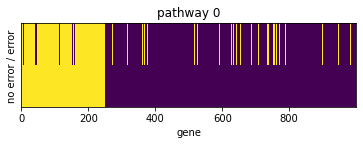

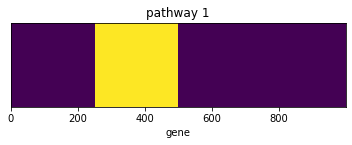

In [173]:
pathway_error_indicator = [True, False]

pathways = sampler.get_pathways(
  num_paths = 2,
  add_error = pathway_error_indicator,
  false_pos = 0.07,
  false_neg = 0.07,
  error_in_block = False
)

for pathway_index, error in enumerate(pathway_error_indicator):
  if not error:
    continue
  false_neg_num = 0
  false_pos_num = 0
  original_path = sampler.loadings_struct[:,pathway_index]
  sampled_path = pathways[pathway_index].boolean_genelist
  for original, sampled in zip(original_path, sampled_path):
    if original != sampled:
      if original:
        false_neg_num += 1
      else:
        false_pos_num += 1
  print(f"Error in pathway {pathway_index}")
  print(f"False negatives: {false_neg_num}")
  print(f"False positives: {false_pos_num}")

for i, path in enumerate(pathways):
  if pathway_error_indicator[i]:
    save_tensor(
      torch.cat(
        torch.atleast_2d(path.boolean_genelist, sampler.loadings_struct[:,i]), 
        dim = 0
      ),
      "gene", "no error / error ", dir + "/structure", 
      f"path_{i}", drop_y_ticks=True, title=f"pathway {i}"
    )
  else:
    save_tensor(
      path.boolean_genelist, "gene", "", dir + "/structure", 
      f"path_{i}", drop_y_ticks=True, title=f"pathway {i}"
    )

The following must be tuned.

In [174]:
# MODEL PARAMETERS
extra_layer = False
dim_x = num_genes
# z consists of annotated elements (pathway indicators) and unannotated elements
unannotated_dim_z = num_facs - len(pathways)
dim_z = len(pathways) + unannotated_dim_z
in_W_dim = 4
out_W_dim = 4
dense_lam = 1e-2
sparse_lam = 1e2
prior_theta_scale = 1
# set this to None to use Euclidean distance instead of logprob
initial_logprob_sigma = None

In [175]:
# TRAINING PARAMETERS
num_train_samples = num_cells
num_epochs = 8000
mc_samples = 1
batch_size = max(num_cells//40, 8)

The following neural network will generate the latent variables that make up z.

In [176]:

# This value adjusts the impact of our learned variances in the sigma_net of
# `inference_net` below. Zero means that the model has no actual connection to
# the output and therefore the standard deviation defaults to the minimum. One
# means that we're learning the real model. This value is flipped to 1 after
# some number of iterations.
stddev_multiple = 0.1

if extra_layer:
  mu_net = torch.nn.Sequential(
    torch.nn.Linear(dim_x, dim_x//4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_x//4, dim_z)
  )
else:
  mu_net = torch.nn.Linear(dim_x, dim_z)

inference_net = NormalNet(

  mu_net=mu_net,

  # Learned standard deviation as a function of the input
  sigma_net=torch.nn.Sequential(
    # inference_net_base,
    torch.nn.Linear(dim_x, dim_z),
    Lambda(torch.exp),
    Lambda(lambda x: x * stddev_multiple + 1e-3)
  )
)

The following generates the annotated portion of the decoder, which takes each latent variable annotated with a pathway and reconstructs that latent variable's gene expression. Each latent variable is reconstructed through two generators, one for the genes in the pathway and one for the genes outside the pathway.

In [177]:
def make_in_pathway_gen(pathway):
  if extra_layer:
    return torch.nn.Sequential(
      torch.nn.Linear(in_W_dim, pathway.num_in//4),
      torch.nn.Sigmoid(),
      torch.nn.Linear(pathway.num_in//4, pathway.num_in)
    )
  else:
    return torch.nn.Linear(in_W_dim, pathway.num_in)

def make_out_pathway_gen(pathway):
  if extra_layer:
    return torch.nn.Sequential(
      torch.nn.Linear(out_W_dim, pathway.num_out//4),
      torch.nn.Sigmoid(),
      torch.nn.Linear(pathway.num_out//4, pathway.num_out)
    )
  else:
    return torch.nn.Linear(out_W_dim, pathway.num_out)
    
annotated_generators = PalavaAnnotatedGenerator(
  pathways=pathways,
  in_path_generators=[make_in_pathway_gen(pathway) for pathway in pathways],
  out_path_generators=[make_out_pathway_gen(pathway) for pathway in pathways],
  in_W_dim=in_W_dim,
  out_W_dim=out_W_dim,
  output_dim=dim_x,
  sparse_lam=sparse_lam,
  dense_lam=dense_lam,
)

The following generates the unannotated portion of the reconstruction from the rest of the latent variables.

In [178]:
if extra_layer:
  unannotated_vae = torch.nn.Sequential(
    torch.nn.Linear(unannotated_dim_z, dim_x//4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_x//4, dim_x)
  )
else:
  unannotated_vae = torch.nn.Linear(unannotated_dim_z, dim_x)

Each of these components needs to be optimized, the learning rates may need tuning.

In [179]:
lr = 5e-4
optimizer_ann = torch.optim.Adam([
  {'params': inference_net.parameters(), 'lr': lr},
  {'params': annotated_generators.generators_parameters(), 'lr': lr},
])

Ws_lr = 1e-5
optimizer_Ws = torch.optim.SGD([
  {'params': [annotated_generators.in_Ws ], 'lr': Ws_lr, 'momentum': 0},
  {'params': [annotated_generators.out_Ws], 'lr': Ws_lr, 'momentum': 0}
])

unann_lr = 5e-4
optimizer_unann = torch.optim.SGD([
  {'params': unannotated_vae.parameters(), 'lr': unann_lr, 'momentum': 0}
])

Each component of the vae model is now ready, except for the prior used to calculate the KL divergence for the latent variables.

In [180]:
prior_z = Normal(
  Variable(torch.zeros(batch_size * mc_samples, dim_z)),
  Variable(torch.ones(batch_size * mc_samples, dim_z))
)

vae = PALAVA(
  pathways=pathways,
  inference_model=inference_net,
  annotated_generative_model=annotated_generators,
  unannotated_generative_model=unannotated_vae,
  prior_z=prior_z,
  prior_theta=NormalPriorTheta(prior_theta_scale),
  optimizers=[optimizer_unann, optimizer_ann, optimizer_Ws],
  initial_logprob_sigma=initial_logprob_sigma
)

We are now ready to train the model!

In [181]:
print_interval = max(num_epochs // 10, 1)
elbo_per_iter = []
for i in range(num_epochs):
  if i > 1000:
    stddev_multiple = 1

  # [batch_size, dim_x]
  Xvar = Variable(X[torch.randperm(num_train_samples)[:batch_size]])

  info = vae.step(
    X=Xvar,
    Ws_lr=Ws_lr,
    mc_samples=mc_samples
  )

  elbo_per_iter.append(info['elbo'].data.item())

  if i % print_interval == 0 or i == num_epochs - 1:
    print()
    print('iter', i)
    print('  ELBO:', info['elbo'].data.item())
    print('    -KL(q(z) || p(z))', -info['z_kl'].data.item())
    print('    loglik term      ', info['loglik_term'].item())
    print('    log p(theta)     ', info['logprob_theta'].data.item())
    print('    log p(W)         ', info['logprob_W'].data.item())
    print(
      '    avg W-in  signal  ', 
      float(torch.mean(torch.abs(vae.annotated_generative_model.in_Ws)))
    )
    print(
      '    avg W-out signal  ', 
      float(torch.mean(torch.abs(vae.annotated_generative_model.out_Ws)))
    )



iter 0
  ELBO: -12212.6923828125
    -KL(q(z) || p(z)) -9.157962799072266
    loglik term       -2211.849609375
    log p(theta)      -9612.26953125
    log p(W)          -379.414794921875
    avg W-in  signal   0.7698684334754944
    avg W-out signal   0.8923256993293762

iter 800
  ELBO: -9997.9140625
    -KL(q(z) || p(z)) -12.35980224609375
    loglik term       -484.63287353515625
    log p(theta)      -9274.6455078125
    log p(W)          -226.27536010742188
    avg W-in  signal   0.7762123346328735
    avg W-out signal   0.5424302220344543

iter 1600
  ELBO: -9687.6689453125
    -KL(q(z) || p(z)) -29.995677947998047
    loglik term       -316.717041015625
    log p(theta)      -9228.7197265625
    log p(W)          -112.2367172241211
    avg W-in  signal   0.7726872563362122
    avg W-out signal   0.26944756507873535

iter 2400
  ELBO: -9466.7705078125
    -KL(q(z) || p(z)) -59.687679290771484
    loglik term       -129.7279815673828
    log p(theta)      -9219.10546875
    log

Now that the model has been trained, we want to visualise the various things that it has learned.

In [182]:
# View the W matrices in and out of each pathway
print("W in:")
print(annotated_generators.in_Ws.data.squeeze())
print("W out:")
print(annotated_generators.out_Ws.data.squeeze())

W in:
tensor([[-0.9092,  2.6397,  0.0977,  0.3753],
        [ 0.7121,  1.3712,  0.1341,  0.2435]])
W out:
tensor([[-0.0600,  0.0962, -0.0597, -0.0662],
        [-0.0000, -0.0000,  0.0000,  0.0000]])


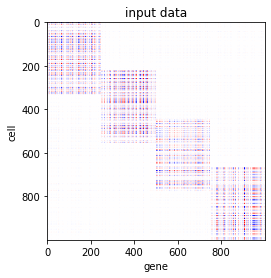

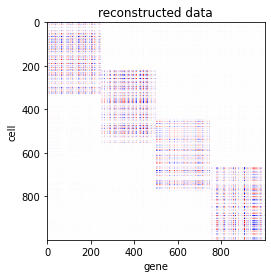

In [183]:
# Visualise the reconstructions, including breaking them down by each annotated
# component as well as the unannotated component

# the latent representation of each cell
activations = inference_net(Variable(X)).mu
# the model's reconstruction of each latent representation
reconstructions = vae.decode(activations).detach()

data_norm = get_combined_norm(X/2, reconstructions/2)

save_tensor(
  X, "gene", "cell", dir + "/structure", "input_data",
  scale_norm=data_norm, title="input data", cmap="bwr"
)
save_tensor(
  reconstructions, 
  "gene", "cell", dir + "/structure", "reconstructed_all_data",
  scale_norm=data_norm, title="reconstructed data", cmap="bwr"
)

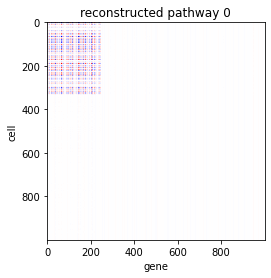

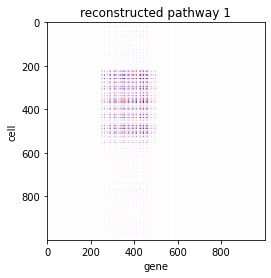

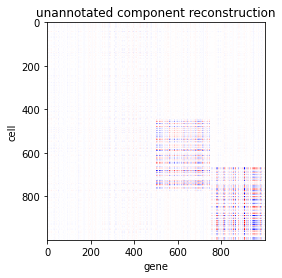

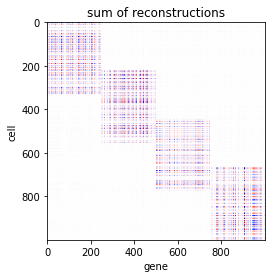

In [184]:
num_paths = len(pathways)

sum = torch.zeros_like(X)
unannotated_component = (
  vae.unannotated_generative_model(activations[:,num_paths:]).detach()
)
sum = sum.add(unannotated_component)

for pathway_index in range(num_paths):
  pathway_contribution = vae.annotated_generative_model.pathway_expression(
    activations[:,:num_paths],
    pathway_index
  ).detach()

  save_tensor(
    pathway_contribution, 
    "gene", "cell", dir + "/structure", 
    f"pathway {pathway_index} reconstruction", scale_norm=data_norm,
    title=f"reconstructed pathway {pathway_index}", cmap="bwr"
  )
  sum = sum.add(pathway_contribution)

save_tensor(
  unannotated_component,
  "gene", "cell", dir + "/structure", 
  "reconstructed_unannotated_compnt", scale_norm=data_norm,
  title="unannotated component reconstruction", cmap="bwr"
)
save_tensor(
  sum.detach(), 
  "gene", "cell", dir + "/structure", 
  "reconstructed_components_summed", scale_norm=data_norm, 
  title="sum of reconstructions", cmap="bwr"
)

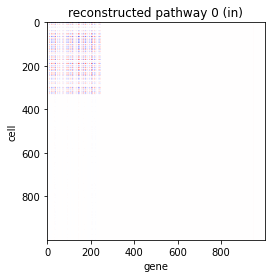

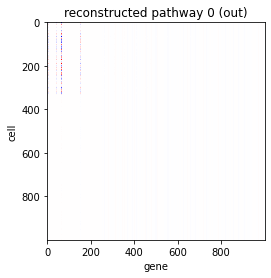

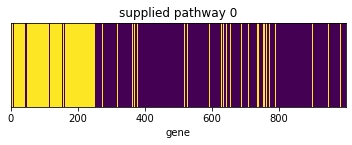

In [185]:
for pathway_index in range(num_paths):
  if torch.sum(torch.abs(annotated_generators.out_Ws[pathway_index])) > 0:
    in_path_cmpnt = vae.annotated_generative_model.pathway_expression(
        activations[:,:num_paths],
        pathway_index,
        in_path_only=True
    ).detach()

    out_of_path_cmpnt = vae.annotated_generative_model.pathway_expression(
        activations[:,:num_paths],
        pathway_index,
        out_of_path_only=True
    ).detach()
    
    save_tensor(
      in_path_cmpnt, 
      "gene", "cell", dir + "/structure", 
      f"pathway {pathway_index} reconstruction (in)", ind_norm=True,
      title=f"reconstructed pathway {pathway_index} (in)",
      cmap="bwr"
    )
    save_tensor(
      out_of_path_cmpnt, 
      "gene", "cell", dir + "/structure", 
      f"pathway {pathway_index} reconstruction (out)",
      title=f"reconstructed pathway {pathway_index} (out)", ind_norm=True,
      cmap="bwr"
    )
    save_tensor(
      pathways[pathway_index].boolean_genelist.t(),
      "gene", "", dir + "/structure", f"path_{pathway_index}", 
      title=f"supplied pathway {pathway_index}", drop_y_ticks=True
    )

[212, 230, 22, 144, 628]
[775, 681, 566, 765, 627]
in: gene 212 ; 0.002590494928881526


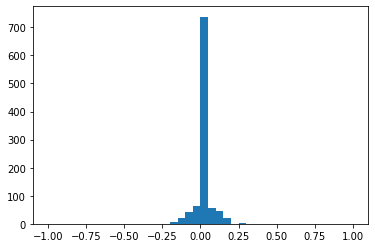

in: gene 230 ; 0.08519794791936874


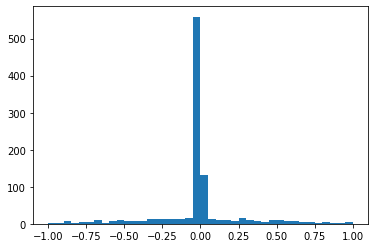

in: gene 22 ; 0.01779279299080372


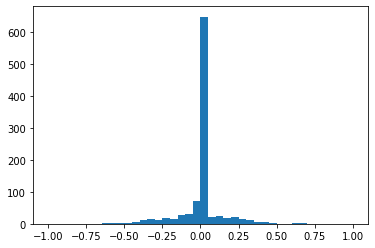

in: gene 144 ; 1.1738767623901367


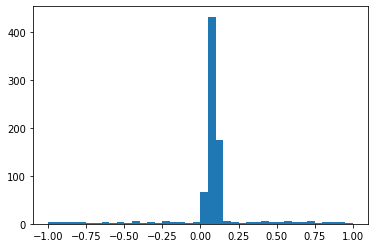

in: gene 628 ; 4.879764674114995e-06


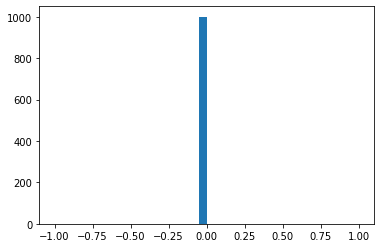

out: gene 775 ; 8.465788710054767e-07


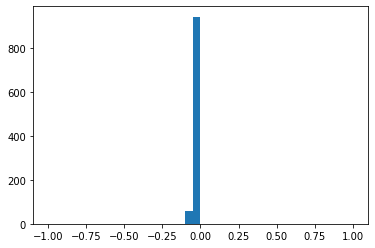

out: gene 681 ; 5.105867284527221e-09


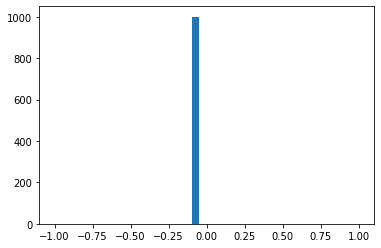

out: gene 566 ; 6.0575366944704e-10


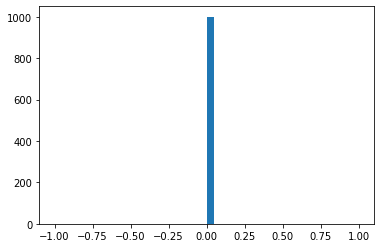

out: gene 765 ; 2.466116484356462e-07


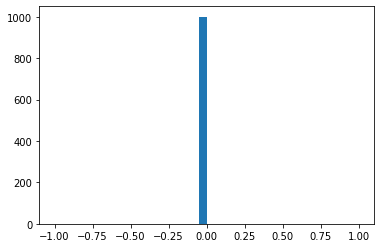

out: gene 627 ; 1.1584336334635736e-07


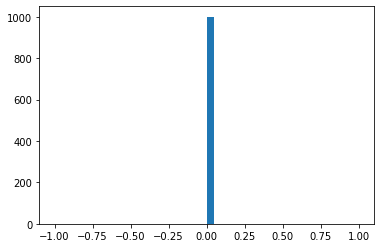

In [186]:
num_examples = 5

pathway_0_contribution = vae.annotated_generative_model.pathway_expression(
  activations[:,:num_paths],
  0
).detach()

sample_genes_in = random.sample(pathways[0].indexes_in, num_examples)
sample_genes_out = random.sample(pathways[0].indexes_out, num_examples)

print(sample_genes_in)
print(sample_genes_out)

granularity = 20
for i in range(5):
  print(f"in: gene {sample_genes_in[i]}", end="")
  sample_expression_in = pathway_0_contribution[:,sample_genes_in[i]]
  print(f" ; {torch.var(sample_expression_in)}")
  sample_expression_in = [float(i) for i in sample_expression_in]
  plt.hist(
    sample_expression_in, 
    bins = [i/granularity for i in range(-granularity, granularity + 1)]
  )
  plt.show()

for i in range(5):
  print(f"out: gene {sample_genes_out[i]}", end="")
  sample_expression_out = pathway_0_contribution[:,sample_genes_out[i]]
  print(f" ; {torch.var(sample_expression_out)}")
  sample_expression_out = [float(i) for i in sample_expression_out]
  plt.hist(
    sample_expression_out, 
    bins = [i/granularity for i in range(-granularity, granularity + 1)]
  )
  plt.show()


The same trend of larger variance indicating membership of the pathway seems to hold (note 682 is not really in the pathway, it was added in as error). We plot a histogram of the logarithm of the variances to see where a good threshold lies:

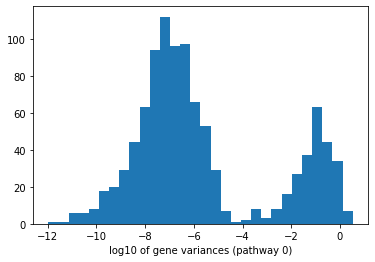

In [187]:
gene_variances = torch.zeros(num_genes)
for i in range(num_genes):
  gene_variances[i] = torch.var(pathway_0_contribution[:,i])

gene_hist = [float(i) for i in torch.log10(gene_variances)]
plt.hist(gene_hist, bins = 30)
plt.xlabel('log10 of gene variances (pathway 0)')
plt.show()

We see two distinct groups that meet just below 1e-4. Using 0.9e-4 as a threshold to classify the genes:

Error in learned pathway 0:
False negatives: 1
False positives: 0


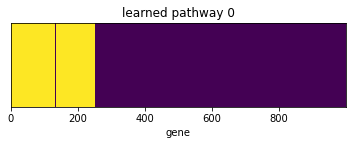

In [188]:
threshold = 0.9e-4
learned_pathway = torch.zeros(num_genes)
for i in range(num_genes):
  learned_pathway[i] = torch.var(pathway_0_contribution[:,i]) > threshold
save_tensor(
  learned_pathway, "gene", "",  dir + "/structure", 
  "learned_pathway_0", drop_y_ticks=True, title = "learned pathway 0"
)
false_neg_num = 0
false_pos_num = 0
for original, sampled in zip(original_path, learned_pathway):
  if original != sampled:
    if original:
      false_neg_num += 1
    else:
      false_pos_num += 1
print(f"Error in learned pathway 0:")
print(f"False negatives: {false_neg_num}")
print(f"False positives: {false_pos_num}")

Compare this with the original error that we supplied the model with: 15 false negatives and 57 false positives. The model has almost perfectly inferred the correct pathway! 

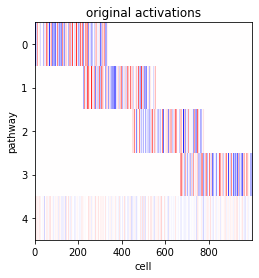

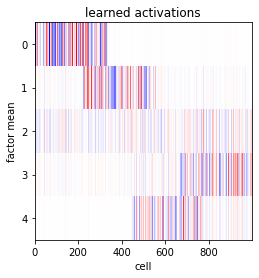

In [189]:
# Visualise the activations we specified alongside the learned activations, 
# on the same scale. This indicates how well the model has learned the
# underlying representation

learned_activations = activations.data.t()

# overwrite earlier sampler.activations file with new scale
save_tensor(
  sampler.activations, "cell", "pathway", dir + "/structure", 
  "activations", title="original activations", cmap="bwr", ind_norm=True
)
save_tensor(
  learned_activations, "cell", "factor mean", dir + "/structure", 
  "activations_learned", title="learned activations", cmap="bwr", ind_norm=True
)

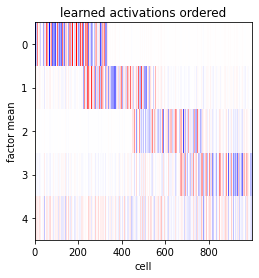

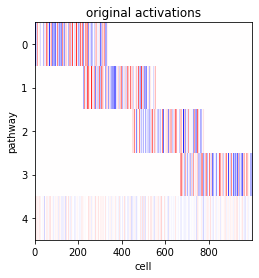

In [190]:
def alternative_sign_and_order(sign_string, order_tuple):
  matrix = learned_activations.clone()
  for row, sign_indicator in enumerate(sign_string):
    if (sign_indicator == "0"):
      matrix[row] *= -1
  matrix[len(pathways):] = torch.index_select(
      matrix[num_paths:],
      dim = 0, 
      index = Variable(torch.LongTensor(order_tuple))
    )
  return matrix

min_distance = None
for order_tuple in permutations(range(unannotated_dim_z)):
  for binary_number in range(2**num_facs):
    binary_number_string = format(binary_number, '0' + str(num_facs) + 'b')
    alternative = alternative_sign_and_order(binary_number_string, order_tuple)
    distance = torch.mean(
      LA.vector_norm(alternative - sampler.activations, dim = 1)
    )
    if min_distance is None or distance < min_distance:
      nearest_alternative = alternative
      min_distance = distance

save_tensor(
  nearest_alternative, "cell", "factor mean", dir + "/structure", 
  "activations_learned_ordered",
  title="learned activations ordered", cmap="bwr", ind_norm=True
)
save_tensor(
  sampler.activations, "cell", "pathway", dir + "/structure", 
  "activations", title="original activations", cmap="bwr", ind_norm=True
)

We can see after the final reordering that the model has learned the activations.

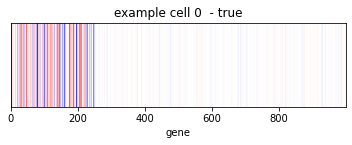

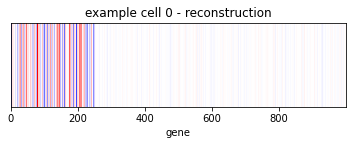

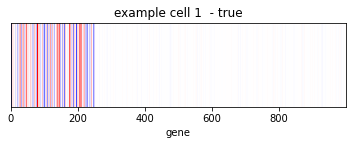

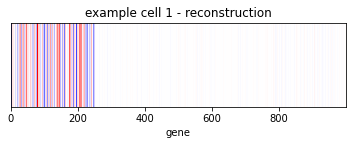

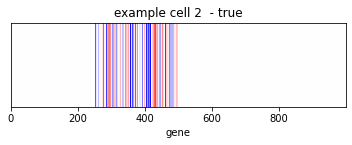

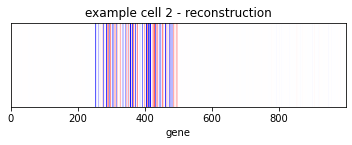

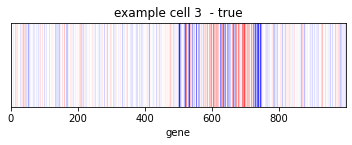

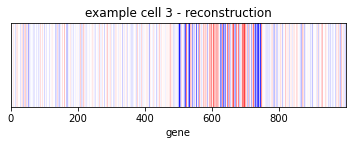

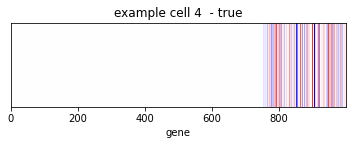

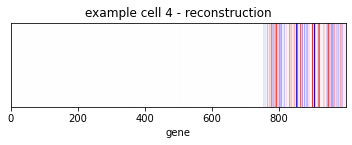

In [191]:
# Finally, visualise a few samples to see how they were reconstructed
def save_img_and_reconstruction(image_index, sample):
  Xvar = Variable(X[[sample]])
  z = inference_net(Xvar).sample()
  Xdash = vae.decode(z).view(dim_x, 1)
  sample_norm = get_combined_norm(Xvar, Xdash)
  save_tensor(
    Xvar.data.contiguous().view(1, dim_x), 
    "gene", 
    "", 
    dir + "/reconstructions",
    'example_{}_true'.format(image_index), 
    scale_norm=sample_norm,
    title='example cell {}  - true'.format(image_index),
    drop_y_ticks=True,
    cmap="bwr"
  )
  save_tensor(
    Xdash.data.t(), 
    "gene", 
    "", 
    dir + "/reconstructions", 
    'example_{}_reconstruction'.format(image_index),
    scale_norm=sample_norm,
    title='example cell {} - reconstruction'.format(image_index),
    drop_y_ticks=True,
    cmap="bwr"
  )

num_examples = 5
for image_index, sample in enumerate(range(0, num_cells, num_cells//num_examples)):
  save_img_and_reconstruction(image_index, sample)